# T035 · GNN-based molecular property prediction

**Note**: This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

* Paula Linh Kramer, 2022, [Volkamer Lab](https://volkamerlab.org/), [NextAID](https://nextaid.cs.uni-saarland.de/) project, Saarland University

## Aim of this talktorial
In this tutorial, we will first explain the basic concepts of graph neural networks (GNNs) and present two different GNN architectures. We apply our neural networks to the `QM9` dataset, which is a dataset containing small molecules. With this dataset, we want to predict molecular properties. We demonstrate how to train and evaluate GNNs step by step using PyTorch Geometric.

### Contents in *Theory*

* GNN Tasks
* Message Passing
* Graph Convolutional Network (GCN)
* Graph Isomorphism Network (GIN)
* Training a GNN
* Applications of GNNs

### Contents in *Practical*

* Dataset
* Defining a GCN and GIN
* Training a GNN
* Evaluating the model

### References

* Articles:
    * Atz, Kenneth, Francesca Grisoni, and Gisbert Schneider. *Geometric Deep Learning on Molecular Representations*, [Nature Machine Intelligence 3.12 (2021): 1023-1032](https://arxiv.org/pdf/2107.12375.pdf)
    * Xu, Keyulu, Weihua Hu, Jure Leskovec, and Stefanie Jegelka. *How Powerful are Graph Neural Networks?*, [International Conference on Learning Representations (ICLR 2019)](https://arxiv.org/abs/1810.00826v3)
    * Welling, Max, and Thomas N. Kipf. *Semi-supervised classification with graph convolutional networks*, [International Conference on Learning Representations (ICLR 2017)](https://arxiv.org/pdf/1609.02907.pdf)
    * Gilmer, Justin, Samuel S. Schoenholz, Patrick F. Riley, Oriol Vinyals, and George E. Dahl. *Neural Message Passing for Quantum Chemistry*, [International conference on machine learning. PMLR, 2017](https://arxiv.org/pdf/1704.01212.pdf)


* Blog posts:
    * Maxime Labonne, *Graph Convolutional Networks: Introduction to GNNs*, [Maxime Labonne](https://mlabonne.github.io/blog/intrognn/)
    * Maxime Labonne, *GIN: How to Design the Most Powerful Graph Neural Network*, [Maxime Labonne](https://mlabonne.github.io/blog/gin/)
    * Vortana Say, *How To Save and Load Model In PyTorch With A Complete Example*, [towardsdatascience](https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee)
    * Michael Bronstein, *Expressive power of graph neural networks and the Weisfeiler-Lehman test*, [towardsdatascience](https://towardsdatascience.com/expressive-power-of-graph-neural-networks-and-the-weisefeiler-lehman-test-b883db3c7c49)
    * Benjamin Sanchez-Lengeling,  Emily Reif, *A Gentle Introduction to Graph Neural Networks*, [Distill](https://distill.pub/2021/gnn-intro/)


* Tutorials:
    * *Pytorch Geometric Documentation*, [Colab Notebooks and Video Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)
    * *Pytorch Geometric Documentation*, [Introduction by Example](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#learning-methods-on-graphs)

## Theory

### Graph Neural Networks

There are several ways to represent molecules which are explained and discussed in **Talktorial T033**. If we work with molecules, one intuitive approach to apply deep learning to certain tasks is to make use of the graph structure of molecules. Graph neural networks can directly work on given graphs. Molecules can easily be represented as a graph, as seen in Figure 1. Given a graph $G=(V, E)$, $V$ describes the vertices or nodes. In molecular graphs, a node $v_i \in \mathbb{R}^{d_v}$ represents an atom. Nodes can have $d_v$ different features, such as atomic number and chirality. Edges usually correspond to covalent bonds between the atoms. Each edge $e_{ij} \in \mathbb{R}^{d_e}$ is described by $d_e$ number of features, which usually represent the bond type. A graph neural network is a network consisting of learnable and differentiable functions that are invariant for graph permutations. Graph neural networks consist of so-called message-passing layers which will be explained in more detail below, followed by more specific explanations of two different GNN architectures. 

<p align="center">
<img src="images/simple-graph.png" alt="simple_graph" width="600"/>
</p>
<p align="center">
    <em> Figure 1: Molecular graph overview. Figure taken from [<a href="https://arxiv.org/pdf/2107.12375.pdf" target="_top">1</a>]
</em>
</p>


#### GNN Tasks

We can perform different tasks with a GNN: 

- Graph-level tasks: one application would be to predict a specific property of the entire graph. This can be a classification task such as toxicity prediction or a regression task. In this tutorial, we will implement a regression task to predict molecular properties. Another graph-level task would be to predict entirely new graphs/molecules. This is especially relevant in the area of drug discovery, where new drug candidates are of interest. 
- Node-level tasks: we can predict a property of a specific node in the graph, e.g. the atomic charges of each atom. We could also predict a new node to be added to the graph. This is often done for molecule generation, where we want to add multiple atoms to form new molecules one after the other. 
- Edge-level tasks: we can predict edge properties, e.g. intramolecular forces between atoms, or a new edge in the graph. In the molecule generation context, we want to predict potential bonds between the atoms. Edge prediction can also be used to infer connections/interactions e.g. in a gene regulatory network. 


#### Message Passing

Instead of MLP layers in standard neural networks, GNNs have message-passing layers, where we collect information about the neighboring nodes. For each node $v$, we look at the direct neighbors $N(v)$ and gather information. Then all the information is aggregated, for example with summation. Then we update the node $v$ with the aggregated messages. If we perform this aggregation and combining, each node contains the information about the direct neighbors (1-hop). If we repeat this $n$ times, we aggregate information about the $n_{th}$ closest neighbors ($n$ -hop). 

$$a_v^{(k)} = \text{aggregate}^{(k)} (\{ h_u^{(k-1)}: u \in N(v) \})$$

$$h_v^{(k)} = \text{combine}^{(k)} (h_v^{(k-1)}, a_v^{(k)})$$

where $h_v^{(k)}$ is the embedding of node $v$ at layer $k$, $N(v)$ are the neighbors of node $v$. 


<p align="center">
<img src="images/gnn_overview.png" alt="simple_graph" width="600"/>
</p>
<p align="center">
    <em> Figure 2: Message passing overview. Figure taken from [<a href="https://medium.com/stanford-cs224w/self-supervised-learning-for-graphs-963e03b9f809" target="_top">2</a>]
</em>
</p>

One important property of a GNN is permutation invariance. This means that changing the order of nodes in the graph should not affect the outcome. For example, when working with adjacency matrices, changing the order of nodes would mean swapping rows and/or columns. However, this does not change any properties of a graph, but the input would differ. In GNNs, we want to overcome this. We, therefore need an aggregation function and a combining function that are permutation invariant, such as using the mean, the maximum or a sum. 
Using a permutation invariant aggregation function ensures that the graph-level outputs are also invariant to permutations. 
In this tutorial, we will explain graph-level regression tasks and in the following, we will present two different GNN architectures.



#### GCN 

One of the simplest GNNs is a Graph Convolutional Network (GCN). For GCNs, we sum over all neighbors of node $v$, including the node $v$ itself and aggregate all information. We divide it by the degree to keep the range of different nodes comparable. The node-wise aggregation function for layer $k$ is

$$h_v^{(k)} = \Theta^{\top} \sum_{u \in N(v) \cup \{v\}} \frac{1}{\sqrt{d_v d_u}} \cdot h_u^{(k-1)}$$

where $d_j$ and $d_i$ denote the degree of node $j$ and $i$, respectively, and $\Theta$ represent trainable weights. 

One disadvantage of GCNs is, that they use a mean-based aggregation and this function is not injective. This means that different graphs can lead to the same graph embedding and the network cannot distinguish between the two graphs anymore. One example is visualized in Figure 3 below. Assuming the node and edge properties are identical, GCNs could create the same hidden embedding for these two graphs.  


<p align="center">
<img src="images/graph.jpeg" alt="simple_graph" width="500"/>
</p>
<p align="center">
    <em> Figure 3: Two indistinguishable graphs using GCNs 
</em>
</p>


#### GIN 
Another type of GNN is the Graph Isomorphism Network (GIN), which has been proposed to overcome the disadvantages of GCNs explained above. The aggregation function is defined as follows

$$h_v^{(k)} = h_\Theta((1+ \epsilon) \cdot h_v^{(k-1)} + \sum_{u \in N(v)} h_u^{(k-1)} )$$

The aggregation function here is a sum. The parameter $\epsilon$ decides on the importance of the node $v$ compared to its neighbors. $h_\Theta$ represents a neural network for all nodes $v$, for example an MLP. The sum aggregation function is more powerful compared to a mean aggregation (used in the GCN above) since we can distinguish between more similar graphs, for example, the two graphs in Figure 3.  


GINs are a good example of a simple network, which still is quite powerful, as they are quite good at distinguishing between non-isomorphic graphs. Two graphs are isomorphic if the graphs are identical except for node permutations. While this might be easily visible for smaller graphs, it is a complex problem for larger graphs. When working with GNNs, we would like the model to give us the same output if the input graphs are isomorphic. On the other hand, we also want the model to be able to differentiate between non-isomorphic graphs and output (possibly) different results. GINs can differentiate between non-isomorphic graphs a lot better than other simple GNNs such as GCN and GraphSage. For example, the two graphs in the figure above have different embeddings using GINs, since we are using a sum-based aggregation without any scaling or averaging. It is proven that GINs are as powerful as the Weisfeiler-Lehman test, a common (but not perfect) isomorphism test for graphs. If you are interested in the WL test or more details on GINs, have a look at the original publication about [GINs](https://arxiv.org/abs/1810.00826v3) or this [blog post](https://towardsdatascience.com/expressive-power-of-graph-neural-networks-and-the-weisefeiler-lehman-test-b883db3c7c49) about the WL test. GINs cannot distinguish between all non-isomorphic graphs, one example is in Figure 4. Each node in both graphs has the same number of neighbors, therefore $h_v$ is the same for all nodes $v$ in both graphs. 

<p align="center">
<img src="images/gin_graphs.jpeg" alt="simple_graph" width="500"/>
</p>
<p align="center">
    <em> Figure 4: Two indistinguishable graphs using GINs
</em>
</p>


#### Training a GNN

Similar to training a standard neural network, different design choices and hyperparameters need to be decided on. We will shortly present some concepts commonly used in neural networks, which can also be used for GNNs. Loss functions and activation functions are already discussed in **Talktorial T022**. We also used the mean squared error loss as well as the ReLU activation function. 


##### Batching

It is common to do batching when training a GNN to improve performance. The batch size indicates how many samples from the training data are fed to the neural network before updating model parameters. Choosing the right batch size is a trade-off between computational cost and generalization. For larger batches, the model is updated fewer times and the training is a lot faster. Models using smaller batches can generalize better, meaning that the test error can be lowered. Since this is not the only hyperparameter, choosing the batch size is also linked to the learning rate, the number of training epochs etc. One way to implement batching in GNNs is to stack the adjacency matrices of all graphs in the batch diagonally and to concatenate the node feature matrices. However, graphs (especially molecular graphs) can have rather sparse adjacency matrices. In this case, it is more efficient to use a sparse representation for the edges. PyTorch Geometric for example uses [edge lists](https://pytorch-geometric.readthedocs.io/en/latest/notes/batching.html), where only the indexes of present edges are saved. These lists are concatenated during batching. 


<p align="center">
<img src="images/batching-ex.png" alt="simple_graph" width="600"/>
</p>
<p align="center">
    <em> Figure 4: Batching in GNNs, image taken from [<a href="https://blog.dataiku.com/graph-neural-networks-part-three" target="_top">3</a>]
</em>
</p>


#### Pooling

Pooling layers help a neural network to reduce dimensionality. This makes the model more robust to variations. In graphs, global pooling layers can produce a graph embedding from the different node embeddings. There are different ways for pooling, the most common ones are: mean, max and sum, which are permutation invariant. Hence, pooling layers are also permutation invariant. 
For our GCN, we use a global mean pooling layer and for our GIN we use a global sum pooling layer, as it was proposed in the original publications listed in the references above. Pooling layers are also very useful to reduce the size of the layer to a fixed size for graph representation, therefore global pooling layers are also referred to as readout layers. 



#### Dropout (Regularization)

One common problem in deep learning tasks is overfitting. This usually means that the dataset used to train the neural network is too small. Applying an overfitted network to a different dataset then leads to a high error in prediction, since the model is fit too closely to the training data and does not generalize well enough. To reduce overfitting, one approach is to use dropout layers, which can lead to a better generalization of the model. During training, nodes are randomly dropped. The probability of dropping nodes is another hyperparameter to be fixed. In each iteration, the nodes in a neural network (and the number of nodes) can therefore differ. This means we incorporate more noise and therefore force the neural network to generalize better. 



### Applications of GNNs

GNNs can be applied to a wide variety of tasks involving graphs, these could be based on small molecules (like in this tutorial), but also proteins (see **Talktorial T038**), gene regulatory networks and many more. Some applications are: 

* Property prediction of molecules, such as toxicity and solubility (see: Wieder, Oliver, et al. *A compact review of molecular property prediction with graph neural networks* [Drug Discovery Today: Technologies 37 (2020): 1-12.](https://www.sciencedirect.com/science/article/pii/S1740674920300305) and *MoleculeNet: a benchmark for molecular machine learning* by Zhenqin Wu et al., [Chemical science 9.2 (2018): 513-530.](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a))
* Generating new molecules, which is especially relevant in the field of drug discovery (for more details, read this review by Tong, Xiaochu, et al. *Generative models for De Novo drug design* [Journal of Medicinal Chemistry 64.19 (2021): 14011-14027](https://pubs.acs.org/doi/full/10.1021/acs.jmedchem.1c00927?casa_token=WhlMtHT6bdEAAAAA%3ATT5MISL_F3LN9lEnddHjZsNpQwuCycQgN02rIYfuSL2BSki12AdH72H4i2KwlhaIltWUPC0ia1g61YQ))
* Inferring new interactions/associations in biological networks, such as gene regulatory networks or protein-protein interaction networks

For a more detailed overview of GNNs and their applications, you can read the article by Zhang, Xiao-Meng, et al. *Graph Neural Networks and Their Current Applications in Bioinformatics* [Frontiers in Genetics 12 (2021)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8360394/). 


## Practical 

For the practical section, we have used PyTorch and PyTorch-Geometric, which helps us to handle graph data efficiently. PyTorch Geometric for example uses sparse matrix representations and implemented efficient graph batching. However, there are also different graph libraries for Python, such as the [Deep Graph Library](https://www.dgl.ai/) which is not covered in this tutorial. 

In [1]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [2]:
# import sys
# if sys.platform.startswith(("linux", "darwin")):
#     !mamba install -q -y -c pyg pyg

In [3]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.transforms import BaseTransform, Compose

In [4]:
# specify the local data path
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Dataset 
For this tutorial, we use the [QM9](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.QM9) dataset, which can be imported with `torch_geometric`. The dataset is part of a benchmarking collection called [MoleculeNet](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a). It contains around $130,000$ small molecules with at most 9 heavy atoms as well as various molecular properties. We will choose one property which we will then try to predict. 

In [5]:
# load dataset
qm9 = QM9(root=DATA)
qm9[0]

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

If you are running this tutorial for the first time, the dataset will be downloaded here. As an example, the first molecule from the dataset is shown below. The dataset contains the following information:
- `x`: contains the different node features, such as atomic number, chirality, hybridization, is aromatic, is ring,
- `edge_index`: adjacency matrix, representing the covalent bonds between the atoms,
- `edge_attributes`: contains the edge features (bond type, is conjugated, stereo configuration),
- `pos`: 3D atom coordinates, we will not use them in this tutorial,
- `z`: atomic numbers,
- `y`: target values, this dataset contains 19 different properties describing each molecule, such as dipole moment, different molecular energies, enthalpy and rotational constants. 


In this tutorial, we only use `x`, `edge_index` and `y` to keep it simple. While the dataset has many regression targets, we will only focus on one of the tasks, which is the prediction of the dipole moment $\mu$. For this tutorial, we only sample a subset of QM9. This keeps the runtime low and this is still enough to show some first results. The dataset is split into training, validation and test sets with a $80:10:10$ split ratio. In addition, we normalize the training data ($\mu=0, \sigma=1$) and apply the same mean and standard deviation to the test and validation set.

In [6]:
class SelectTarget(BaseTransform):
    
    def __init__(self, target_index: int) -> None:
        super().__init__()
        self.target_index = target_index
    
    def forward(self, data):
        data.y = data.y[:, self.target_index]
        return data

class TargetNormalization(BaseTransform):
    
    def __init__(self, mean: torch.Tensor, std: torch.Tensor) -> None:
        super().__init__()
        self.mean = mean
        self.std = std
    
    def forward(self, data):
        data.y = (data.y - self.mean) / self.std
        return data
   
    @classmethod
    def fit(cls, dataset, dim: int = 0, cat_dim: int = 0) -> "TargetNormalization":
        y = torch.cat([dataset.get(i).y for i in range(len(dataset))], dim=cat_dim)
        mean = y.mean(dim=dim, keepdim=True)
        std = y.std(dim=dim, keepdim=True)
        return cls(mean, std)

In [7]:
qm9, perm = qm9.shuffle(return_perm=True)

# data split
data_size = 30000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)

normalize_target = TargetNormalization.fit(qm9[:train_index])
select_dipole_moment = SelectTarget(0)
qm9 = QM9(root=DATA, transform=Compose([normalize_target, select_dipole_moment]))
qm9 = qm9[perm]

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

### Defining a GCN and a GIN

The following two Python classes are the two GNNs we will consider in this tutorial. Both have 3 convolutional layers, one global pooling layer, linear layers, ReLU activation functions between the layers and a dropout layer. 

In [8]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class with 3 convolutional layers and a linear layer"""

    def __init__(self, dim_h):
        """init method for GCN

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = torch.nn.Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [9]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

### Training a GNN

When training a GNN (or any neural network), we have a training set, a validation set and a test set. The training set is used for training, the validation set is used to test the loss in each epoch not only on the training set but also on another dataset (*monitor generalization performance*). The test set is used to calculate the error of the fully trained model using a dataset, which has not been used during the whole training process. 

In [10]:
def training(loader, model, loss, optimizer):
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d.x = d.x.float()

        out = model(d)

        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [11]:
def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    for d in loader:
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [12]:
@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    loss = torch.nn.MSELoss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for d in loader:
        out = model(d)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target

In [13]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target


We have trained both models with 100 epochs and saved the best models under `GCN_best-model-parameters.pt` and `GIN_best-model-parameters.pt`. Since this takes some time, we reduced the number of epochs to 10 for this tutorial for demonstration purposes. The results and the plots below are based on the models trained for 100 epochs. If you want to train your own model using our tutorial, you can change the number of epochs and any other parameters in our models (such as learning rate, batch size, etc.). 

In [14]:
# training GCN for 10 epochs
epochs = 10

model = GCN(dim_h=128)

# Remember to change the path if you want to keep the previously trained model
gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GCN_model.pt"
)

Epoch: 0, Train loss: 0.9408459663391113, Val loss: 0.9395796656608582
Epoch: 2, Train loss: 0.8737967610359192, Val loss: 0.8975748419761658
Epoch: 4, Train loss: 0.8395575881004333, Val loss: 0.8604536056518555
Epoch: 6, Train loss: 0.8120918869972229, Val loss: 0.8164269924163818
Epoch: 8, Train loss: 0.7776891589164734, Val loss: 0.7939310669898987


In [15]:
# Training GIN for 10 epochs
model = GIN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GIN_model.pt"
)

Epoch: 0, Train loss: 0.7124184966087341, Val loss: 0.6146427989006042
Epoch: 2, Train loss: 0.5309476852416992, Val loss: 0.45846861600875854
Epoch: 4, Train loss: 0.5072658061981201, Val loss: 0.46316641569137573
Epoch: 6, Train loss: 0.49279478192329407, Val loss: 0.48695334792137146
Epoch: 8, Train loss: 0.47364604473114014, Val loss: 0.4536668658256531


### Evaluating the model 

For evaluation, we use a validation dataset to find the best model and a test set, to test our model on unseen data. 
First, we plotted the losses of our training and validation sets. As expected, the GIN model has a lower training and validation loss. 


In [16]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    """Plot the loss for each epoch

    Args:
        epochs (int): number of epochs
        train_loss (array): training losses for each epoch
        val_loss (array): validation losses for each epoch
    """
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [17]:
def plot_targets(pred, ground_truth):
    """Plot true vs predicted value in a scatter plot

    Args:
        pred (array): predicted values
        ground_truth (array): ground truth values
    """
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

When looking at the losses for each epoch, we can see that the GIN model performs better overall. We can also see that the training loss is often lower compared to the validation loss. This is normal since the training loss describes the error of the model using the training set, which is the dataset used for improving the model. The validation loss is calculated on a separate dataset, which is not used for updating the model weights. Therefore, the error is often higher. This is also the reason, the validation loss sometimes fluctuates more. As long as both losses show a decreasing tendency, this is not problematic. It is important to have a low training loss and a low validation loss. 

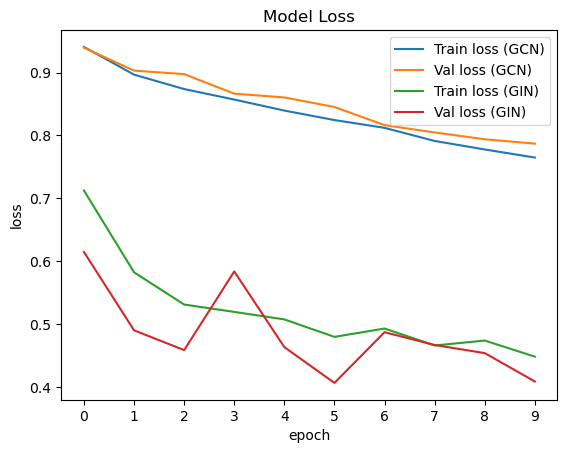

In [18]:
# Plot overall losses of GIN and GCN

plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss)

Then, we also plotted the actual predictions of our target value compared to the ground truth for the GIN model, since this model performs better.

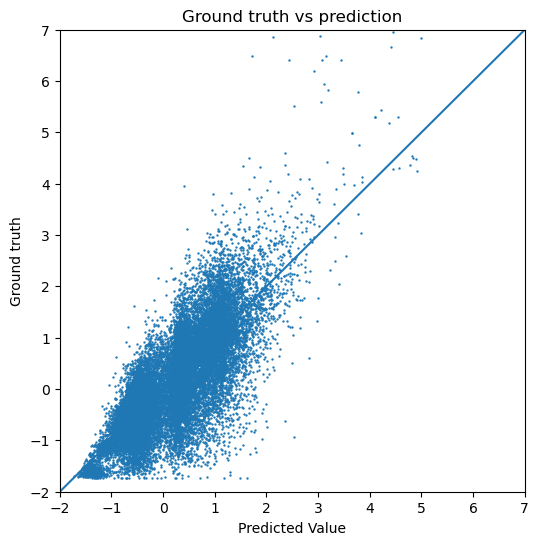

In [19]:
# Plot target and prediction for training data

plot_targets(gin_train_target, gin_train_y_target)

Below, we have calculated the test loss for both the GCN and the GIN. We also plot the predicted dipole moment compared to the ground truth for both models. If we are interested in the actual numeric range of the predicted dipole moment, the normalization applied during the preprocessing should be subtracted again. Since we only visualize the data in our evaluation, this does not make a difference. In the figures below, we can see that the GIN model performs a lot better compared to the GCN since the test error is lower. 

Test Loss for GCN: 0.6379697918891907


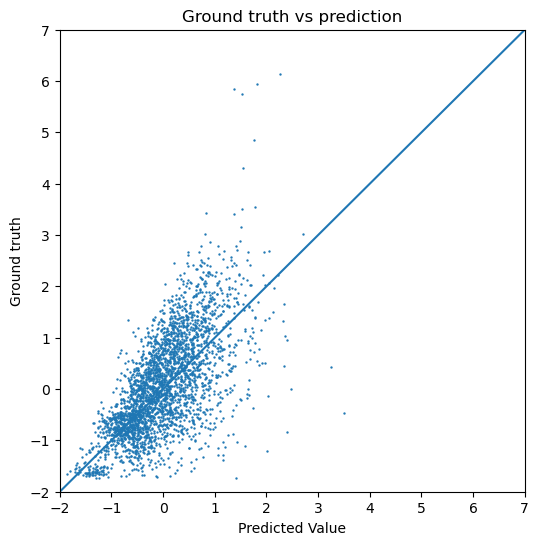

In [20]:
# Calculate test loss from the best GCN model (according to validation loss)

# load our model
model = GCN(dim_h=128)
model.load_state_dict(torch.load("GCN_best-model-parameters.pt"))

# calculate test loss
gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model)

print("Test Loss for GCN: " + str(gcn_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gcn_test_target, gcn_test_y)

Test Loss for GIN: 0.3145371675491333


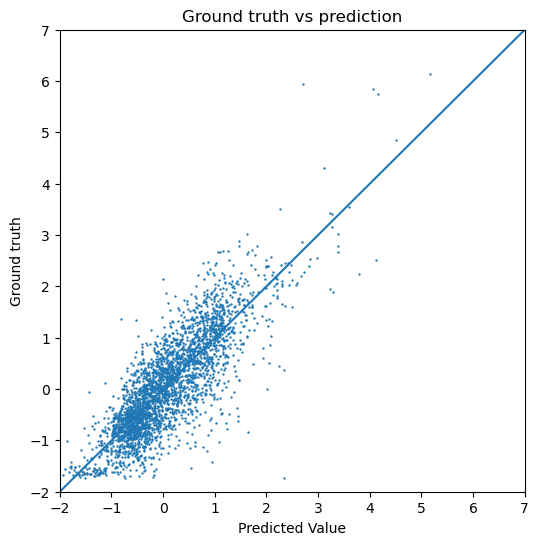

In [21]:
# Calculate test loss from the best GIN model (according to validation loss)

# load our model
model = GIN(dim_h=64)
model.load_state_dict(torch.load("GIN_best-model-parameters.pt"))

# calculate test loss
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model)

print("Test Loss for GIN: " + str(gin_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gin_test_target, gin_test_y)

## Discussion 

In this talktorial we have first presented two different graph neural networks. We applied these two GNNs to a molecular dataset to predict molecular properties. We showed how to train and evaluate a simple GNN using *pytorch* and *pytorch_geometric*. This model can be used for any type of graph-level regression and, with small changes (such as the loss function), graph-level classification is also easy. 


One disadvantage of GNNs is that the quality of the model is extremely data-dependent, the more of the chemical space is covered in the training set, the better the performance would be on new, unseen data. In addition, training a model can be rather complex, since there are many parameters influencing the model. Model parameters, such as learning rate, batch size and number of hidden dimensions could be more thoroughly evaluated to improve the model. To apply this to real tasks, first, a bigger dataset is needed. When using the whole QM9 dataset and not only a small subset, the performance will increase. In addition, the model parameters can also still be optimized. The model architecture can also still be adapted. These changes could lead to longer runtimes, which is why we have chosen this simplified version for demonstration purposes. 


## Quiz

1. What is the difference between a GCN and GIN? 
2. How would you change the model for a classification task? 
3. What other parameters can be tuned for better model performance? 